In [1]:
## Plotting/other packages
import os
import h5py
import math
import time
from typing import Set, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import diffrax as dfx
from diffrax import diffeqsolve, Dopri5, Tsit5, ODETerm, SaveAt, PIDController
import pprint as pp
import jax
from jax import lax, grad, random, jacfwd, jacrev, jit
import jax.numpy as jnp
import equinox as eqx


from cdcm_utils.cdcm_jax import make_cdcm_to_jaxvf
from cdcm import *
from duffing_oscillator import make_duff_osc_sys

/Users/smanikka/miniforge3/envs/py39env/lib/python3.9/site-packages/diffrax/adjoint.py:665: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  _loop_backsolve.defvjp(_loop_backsolve_fwd, _loop_backsolve_bwd)


#### Utilities ####

In [2]:
def plot_prediction(data_dict, sys, test_saver, t_data):
    x1_data = data_dict[sys.dho.x1]
    x2_data = data_dict[sys.dho.x2]
    x1_pred = fetch_save_data(
        path=f"{sys.name}/dho/x1",
        test_saver=test_saver,
    )
    x2_pred = fetch_save_data(
        path=f"{sys.name}/dho/x2",
        test_saver=test_saver,
    )
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    ax.plot(t_data,x1_data,'c',label='x1_data')
    ax.plot(t_data, x2_data,'y',label='x2_data')
    ax.plot(t_data, x1_pred,'r--',label='x1 pred')
    ax.plot(t_data, x2_pred,'k-.',label='x2 pred')
    plt.legend()
    plt.show()


def get_simuln_result(sys, max_steps, data_dict):
    def set_ic():
        if data_dict:
            sns = list(data_dict.keys())
            for sn in sns:
                sn.value = data_dict[sn][0]
        
    file_name = "damped_simple_harmonic_egs.h5"

    if os.path.exists(file_name):
        os.remove(file_name)

    saving_frac = 1 # saving done every saving_frac*dt instant
    test_saver = SimulationSaver(
        file_name,
        sys,
        max_steps=math.ceil(max_steps/saving_frac)
    )
    simulator = Simulator(sys)

    now = time.time()
    simulator.add_event(0., set_ic)
    for i in range(max_steps):
        simulator.forward()
        if i%saving_frac==0:
            test_saver.save()
        simulator.transition()
    print('time taken (s)',time.time()-now)
    return test_saver


def fetch_save_data(path,test_saver,sp=''):
    res = test_saver.file_handler[path][:]
    if sp:
        np.savetxt(sp, res, delimiter=",")
        print('saved')
    return res

get_names = lambda x: [i.name for i in x]

### cdcm system and simulation ###

In [3]:
# some parameters for simulation
dt = 0.001
max_steps = 250*20
to_s = 0.
tmax_s = max_steps*dt

# time and input signal data creation for cdcm system
t_data = np.arange(0.,max_steps*dt,dt)
force_data = np.cos(t_data)
input_dict = {"force":force_data}

input_data_df = pd.DataFrame(input_dict)
input_data_df.head()

# This is for cdcm as we need to simulate the system using cdcm here.
# This is not required or can be dummy if we don't simulate using cdcm.
input_data = {
    "data":input_data_df,
    "name":"input_sys",
}
kwargs = {"input_data":input_data}

# cdcm system creation 
duff_osc_sys = make_duff_osc_sys(
    dt = dt,
    name="duff_osc_sys",
    **kwargs,
)

In [4]:
sim = 1
if sim:
    cdcm_simn_res = get_simuln_result(
        sys=duff_osc_sys,
        max_steps=max_steps,
        data_dict={}
    )

time taken (s) 9.718146085739136


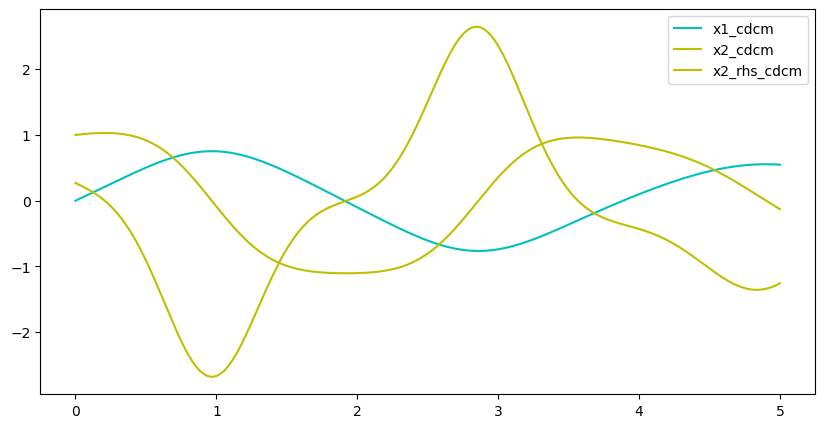

In [5]:
if sim:
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    x1s = fetch_save_data(
                "duff_osc_sys/duff_osc/x1",
                cdcm_simn_res,
            )
    x2s = fetch_save_data(
                "duff_osc_sys/duff_osc/x2",
                cdcm_simn_res,
            )
    x2_rhss = fetch_save_data(
        "duff_osc_sys/duff_osc/x2_rhs",
        cdcm_simn_res
    )
    ax.plot(t_data,x1s,'c',label='x1_cdcm')
    ax.plot(t_data, x2s,'y',label='x2_cdcm')
    ax.plot(t_data, x2_rhss,'y',label='x2_rhs_cdcm')
    plt.legend()
    plt.show()

### cdcm to diffrax ###

In [6]:
force_absname = "duff_osc_sys/duff_osc/input_sys/force"
# This is for diffrax. The keys should be "data", "t_data"
input_dict = {
    force_absname :{"data":force_data,"t_data":t_data}
}

In [13]:
# We make vf object passing cdcm system and cdcm sys clock.dt nodes
vf_obj = make_cdcm_to_jaxvf(
    cdcm_sys=duff_osc_sys,
    cdcm_sys_dt=duff_osc_sys.clock.dt.value,
)
# We obtain the vector field corresponding to the cdcm system by passing the input_dict
vector_field = vf_obj.get_vector_field(input_dict)
# params_set, vars_set, states_set are the sets containing cdcm system nodes of different corresponding types. 
# ofl is the ordered function list which contains the Function and Transition objects of cdcm system in
# the evaluation order.
params_set, vars_set, states_set, ofl = vf_obj.params_set,vf_obj.vars_set,vf_obj.states_set,vf_obj.ordered_fn_list

In [14]:
print(get_names(vars_set))

['y2', 'y1', 'x2_rhs']


In [15]:
print(get_names(states_set))
# We obtain the index corresponding to the states by passing the states set and absname of the states we want.
# This index is used to obtain the solution of the states we want from the solution return by diffrax.
sol_idx = [vf_obj.get_idx_of_qty_at_path(states_set,i) 
           for i in [duff_osc_sys.duff_osc.x1.absname, duff_osc_sys.duff_osc.x2.absname]
          ]
print(sol_idx)

['x2', 'x1', 't']
[1, 0]


In [16]:
#print(duff_osc_sys.sys_dag_for_diffrax)

In [17]:
args=[i.value for i in params_set]
dt_idx = vf_obj.get_idx_of_qty_at_path(params_set,duff_osc_sys.clock.dt.absname)
print(dt_idx)
args[dt_idx]=dt

3


In [18]:
key, subkey = random.split(random.PRNGKey(1234))
x0 = np.zeros(3)
x0[sol_idx[0]] = 0.
x0[sol_idx[1]] = 1.


import time
now = time.time()


def ODESolver(args):
    # We solve using the diffrax. Ignore the adjoint related arguments.
    # The idea here is we pass the vector field obtained to solve the system. 
    sol = diffeqsolve(
        ODETerm(vector_field),
        Tsit5(),
        #Dopri5(), 
        to_s, 
        tmax_s, 
        dt0=dt,
        y0=x0,
        args=args, 
        saveat=SaveAt(
                ts=t_data, 
                fn=vf_obj.get_state_and_vars, # comment this if only state required
        ),
        #AD through Solver graph, only reverse mode
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=200), 
        
        #Both forward and reverse mode. Prefer only if forward mode req else
        # RecursiveCheckpoint
        #adjoint=dfx.DirectAdjoint(),

        # used when solving towards a steady state. ie rhs=0
        #adjoint=dfx.ImplicitAdjoint(),
        
        # Continuous Adjoint ODE Solving backward in time. Only reverse mode.
        # Gradients will be approximate.
        # adjoint=dfx.BacksolveAdjoint(), 
        max_steps=50000
    )
    return sol

# @jit
def soln_for_gradient(args):
    sol = run_dyn_sys(args)
    return sol.ys

state_sol, var_sol = ODESolver(args).ys
print('time taken',time.time()-now) 

time taken 0.4063899517059326


In [19]:
print(state_sol.shape, var_sol.shape)

(5000, 3) (5000, 3)


In [20]:
x1_idx = vf_obj.get_idx_of_qty_at_path(states_set,duff_osc_sys.duff_osc.x1.absname)
x2_idx = vf_obj.get_idx_of_qty_at_path(states_set,"duff_osc_sys/duff_osc/x2")
x2_rhs_idx = vf_obj.get_idx_of_qty_at_path(vars_set,"duff_osc_sys/duff_osc/x2_rhs")

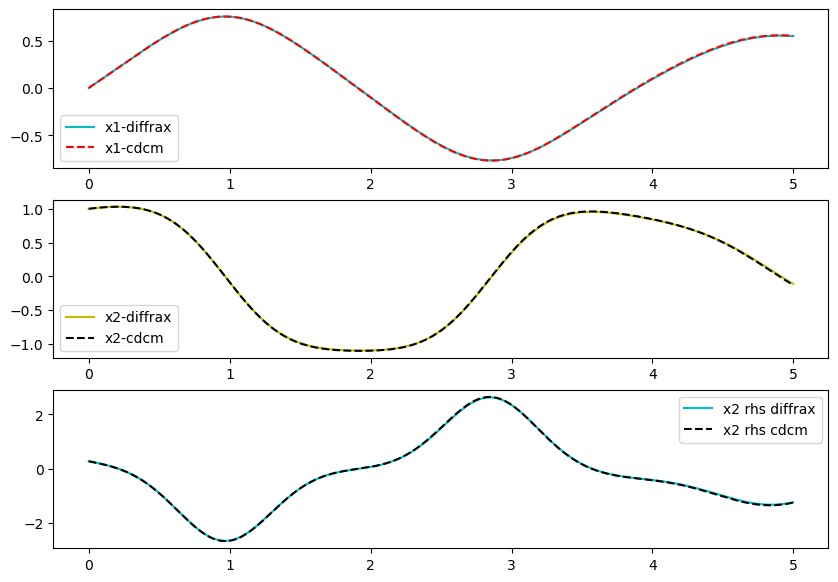

In [21]:
fig,ax=plt.subplots(3,1,figsize=(10,7))
ax[0].plot(t_data,state_sol[:,x1_idx],'c',label='x1-diffrax')
ax[0].plot(t_data,x1s,'--r',label='x1-cdcm')
ax[1].plot(t_data,state_sol[:,x2_idx],'y',label='x2-diffrax')
ax[1].plot(t_data,x2s,'--k',label='x2-cdcm')
ax[2].plot(t_data, var_sol[:,x2_rhs_idx],"c",label="x2 rhs diffrax")
ax[2].plot(t_data, x2_rhss,"--k",label="x2 rhs cdcm")
for i in [0,1,2]: ax[i].legend()
plt.show()